In [ ]:
import os
from glob import glob

import numpy as np
import xarray as xr
import dask

In [ ]:
# Test case
ds_forcing = xr.open_dataset(
    "/storage/group/pches/default/users/dcl5300/wbm_soilM_uc_2024_DATA/projections/eCONUS/forcing/LOCA2/ACCESS-CM2_r1i1p1f1_ssp245.zarr/",
    engine="zarr",
    chunks="auto",
)

ds_soilM = xr.open_dataset(
    "/storage/group/pches/default/users/dcl5300/wbm_soilM_uc_2024_DATA/projections/eCONUS/out/LOCA2/ACCESS-CM2_r1i1p1f1_ssp245_MOSAIC_kge.nc"
)

In [ ]:
151 * 30 / 1024 * 2340 / 1024

10.109138488769531

In [ ]:
(2100 - 2016) * 365

30660

In [76]:
ds_forcing = ds_forcing.isel(time=slice(1000))
ds_soilM = ds_soilM.isel(time=slice(1000))

In [ ]:
ds_forcing = ds_forcing.astype("float32")

In [ ]:
# Convert calendar
ds_forcing["time"] = ds_forcing.indexes["time"].normalize()
ds_forcing = ds_forcing.convert_calendar(calendar="noleap", dim="time")

In [ ]:
ds_forcing["lat"] = ds_forcing["lat"].astype(np.float32)
ds_forcing["lon"] = ds_forcing["lon"].astype(np.float32)

In [ ]:
# Combine
ds = xr.merge([ds_forcing, ds_soilM], join="inner").load()

In [ ]:
%%time
ds = ds.chunk({"time": 365, "lat": -1, "lon": -1})
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in ds.data_vars}
ds.to_netcdf("./test5.nc", encoding=encoding, mode="w")

CPU times: user 11.2 s, sys: 137 ms, total: 11.3 s
Wall time: 11.6 s


In [ ]:
ds_test = xr.open_dataset("./test5.nc")

In [84]:
ds_test

<xarray.Dataset> Size: 468MB
Dimensions:    (lat: 194, lon: 317, time: 634)
Coordinates:
  * lat        (lat) float32 776B 25.19 25.31 25.44 25.56 ... 49.06 49.19 49.31
  * lon        (lon) float32 1kB -106.6 -106.4 -106.3 ... -67.31 -67.19 -67.06
  * time       (time) object 5kB 2016-01-01 00:00:00 ... 2017-09-26 00:00:00
Data variables:
    pr         (time, lat, lon) float32 156MB ...
    tas        (time, lat, lon) float32 156MB ...
    soilMoist  (time, lat, lon) float32 156MB ...
Attributes:
    regrid_method:  conservative

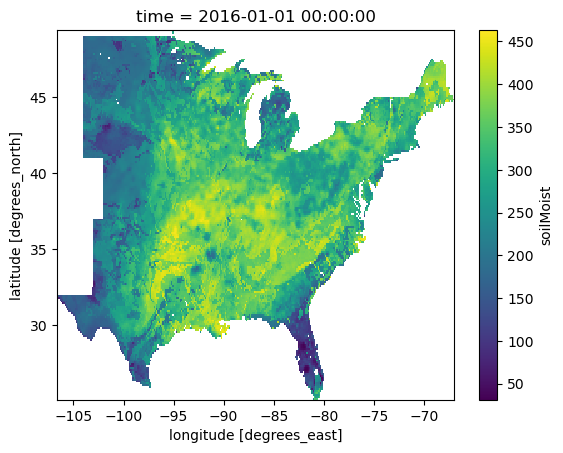

In [ ]:
ds.isel(time=0)["soilMoist"].plot()

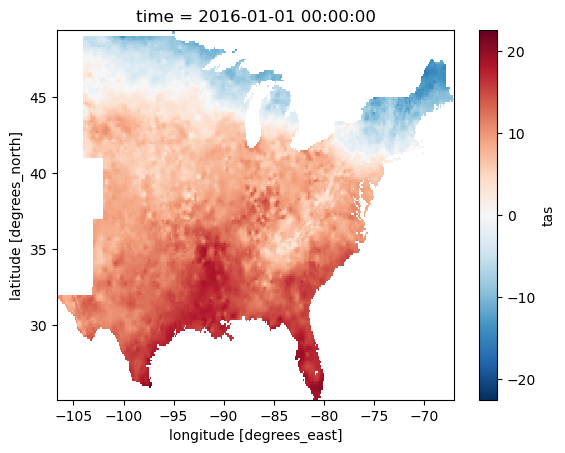

In [ ]:
ds.isel(time=0)["tas"].plot()

In [ ]:
ds_soilM.resample(time="ME").mean()

<xarray.Dataset> Size: 251MB
Dimensions:    (time: 1020, lat: 194, lon: 317)
Coordinates:
  * lon        (lon) float32 1kB -106.6 -106.4 -106.3 ... -67.31 -67.19 -67.06
  * lat        (lat) float32 776B 25.19 25.31 25.44 25.56 ... 49.06 49.19 49.31
  * time       (time) object 8kB 2016-01-31 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    soilMoist  (time, lat, lon) float32 251MB nan nan nan nan ... nan nan nan

In [14]:
ds_forcing

<xarray.Dataset> Size: 31GB
Dimensions:  (lat: 194, lon: 317, time: 31411)
Coordinates:
  * lat      (lat) float64 2kB 25.19 25.31 25.44 25.56 ... 49.06 49.19 49.31
  * lon      (lon) float64 3kB -106.6 -106.4 -106.3 ... -67.31 -67.19 -67.06
  * time     (time) datetime64[ns] 251kB 2015-01-01T12:00:00 ... 2100-12-31T1...
Data variables:
    pr       (time, lat, lon) float64 15GB ...
    tas      (time, lat, lon) float64 15GB ...
Attributes:
    regrid_method:  conservative

In [10]:
ds

<xarray.Dataset> Size: 0B
Dimensions:    (lat: 0, lon: 0, time: 0)
Coordinates:
  * lat        (lat) float64 0B 
  * lon        (lon) float64 0B 
  * time       (time) object 0B 
Data variables:
    pr         (time, lat, lon) float64 0B ...
    tas        (time, lat, lon) float64 0B ...
    soilMoist  (time, lat, lon) float32 0B ...
Attributes:
    regrid_method:  conservative

In [ ]:
# Original LOCA
ds_loca = xr.open_dataset(
    "/storage/group/pches/default/public/LOCA2/ACCESS-CM2/0p0625deg/r1i1p1f1/ssp245/tasmax/tasmax.ACCESS-CM2.ssp245.r1i1p1f1.2015-2044.LOCA_16thdeg_v20220413.nc"
)